# Charactor-level RNN for wiki

    modified from https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

import time
import math
import random
import torch
import torch.nn as nn

# # Plus EOS marker
# keywords_dict = {}
# keywords_dict['all_letters'] = string.ascii_letters + " .,;'-"
# keywords_dict['n_letters'] = len(keywords_dict['all_letters']) + 1

# def findFiles(path): return glob.glob(path)

# # Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
# def unicodeToAscii(s, keywords_dict):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#         and c in keywords_dict['all_letters']
#     )

# # Read a file and split into lines
# def readLines(filename, keywords_dict):
#     lines = open(filename, encoding='utf-8').read().strip().split('\n')
#     return [unicodeToAscii(line, keywords_dict) for line in lines]

# # Build the category_lines dictionary, a list of lines per category
# name_list = []
# for filename in findFiles('data/names/*.txt'):
#     category = os.path.splitext(os.path.basename(filename))[0]
#     name_list.extend(readLines(filename, keywords_dict))
    
# keywords_dict['name_vector'] = name_list

In [ ]:
# parameter



In [8]:
data = open(r'data/shakespeare_input.txt', 'r').read() # should be simple plain text file
data = ''.join(data.split(', &c'))
data = ''.join(data.split(', &C'))
data = ''.join(data.split(',\' &c'))
data = ''.join(data.split(' &c'))
data = ''.join(data.split('&c'))
data = ''.join(data.split('['))
data = ''.join(data.split(']'))
data = data[:1000000]
data= data
chars = list(set(data))
# 
data_size, vocab_size = len(data), len(chars)
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
print('data has %d characters, %d unique.' % (data_size, vocab_size))

keywords_dict={}
# keywords_dict['hidden_size'] = 100
keywords_dict['seq_length'] = 25
keywords_dict['learning_rate'] = 0.1
keywords_dict['data_size'] = len(data)

keywords_dict['all_letters'] = ''.join(sorted(chars))
keywords_dict['n_letters'] = len(chars)
print(keywords_dict)

data has 1000000 characters, 63 unique.
{'learning_rate': 0.1, 'n_letters': 63, 'all_letters': "\n !',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz", 'data_size': 1000000, 'seq_length': 25}


In [46]:
len(data*3)

41159385

In [9]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line, keywords_dict):
    all_letters = keywords_dict['all_letters']
    n_letters = keywords_dict['n_letters']
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
#         print(letter)
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line, keywords_dict):
    all_letters = keywords_dict['all_letters']
    n_letters = keywords_dict['n_letters']
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def createTrainingExample(line, keywords_dict):
#     category, line = randomTrainingPair()
#     line = randomChoice(keywords_dict['name_vector'])
#     category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line[:-1], keywords_dict)
#     print(input_line_tensor)
    target_line_tensor = targetTensor(line[1:], keywords_dict)
#     print(target_line_tensor)

#     return category_tensor, input_line_tensor, target_line_tensor
    return input_line_tensor, target_line_tensor

In [10]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [35]:
# max_length = 100

# # Sample from a category and starting letter
# def sample(keywords_dict, start_letter='W'):
#     with torch.no_grad():  # no need to track history in sampling
# #         category_tensor = categoryTensor(category)
#         _input = inputTensor(start_letter, keywords_dict)
#         hidden = rnn.initHidden()

#         output_name = start_letter

#         for i in range(max_length):
#             output, hidden = rnn(_input[0].to(device), hidden.to(device))
#             topv, topi = output.topk(1)
#             topi = topi[0][0]
#             letter = keywords_dict['all_letters'][topi]
#             output_name += letter
#             _input = inputTensor(letter, keywords_dict)

#         return output_name
# sample(keywords_dict)

In [36]:
# with torch.no_grad():  # no need to track history in sampling
# #         category_tensor = categoryTensor(category)
#         _input = inputTensor(start_letter, keywords_dict)
#         hidden = rnn.initHidden()

#         output_name = start_letter

#         for i in range(25):
#             output, hidden = rnn(_input[0].to(device), hidden.to(device))
#             topv, topi = output.topk(1)
#             topi = topi[0][0]
#             letter = keywords_dict['all_letters'][topi]
#             output_name += letter
#             _input = inputTensor(letter, keywords_dict)

In [39]:
class RNN3(nn.Module):
    def __init__(self, input_size=keywords_dict['n_letters'], hidden_size=512, output_size=keywords_dict['n_letters'], n_layers=3):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, init):
        """
        input: a batch of one hot charactors [25, 1, 68]"""
        hidden = init
        return_ = []
        for i in range(input.size(0)):
            _input = input[i:i+1]
            output, hidden = self.rnn(_input, hidden)
            output = self.fc(output)
            output = self.softmax(output)
            return_.append(output)
        return return_, hidden
    
    def prediction(self, input, hidden):
        """        
        input: a batch of one hot charactors [1, 1, 68]"""
        output, hidden = self.rnn(input, hidden)
        output = self.fc(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)

In [20]:
def init_prediction():
    _test_a = torch.zeros(3, 1, 512)
    return torch.tanh(torch.nn.init.normal_(_test_a, mean=0.0, std=1.0))

# check first layer



In [ ]:
from  torch import autograd 

input_line_tensor, target_line_tensor = createTrainingExample(data[0:26], keywords_dict)
rnn_ = RNN3(keywords_dict['n_letters'], 512, keywords_dict['n_letters'], 3)
if torch.cuda.is_available:
    rnn_.cuda()
# _ = input_line_tensor.long()
_init = rnn_.initHidden(1)
output,_init = rnn_(input_line_tensor.cuda(), _init)
# output = rnn_(input_line_tensor.cuda())
# # input_line_tensor[0:1]
rnn_.prediction(input_line_tensor[0:1].cuda(), rnn_.initHidden(1))

In [ ]:
output, _init = rnn_(input_line_tensor.cuda(), _init)
print(_init)
# rnn_.prediction(input_line_tensor[0:1].cuda(), rnn_.initHidden(1))

In [ ]:
rnn =  RNN3(n_letters, 512, n_letters, 3).to(device)
rnn.initHidden(1)

# Start trainning

In [37]:
true_training_rnn = None

In [61]:
print(len(data*3))

9000000


In [ ]:
from torch.nn.utils import clip_grad_norm_
def running(keywords_dict, training_rnn=None, epoch=1):
    n_letters = keywords_dict['n_letters']
    if training_rnn:
        print('loading pre model')
        rnn = training_rnn
    else:
        rnn =  RNN3(n_letters, 120, n_letters, 3)
    
    rnn.to(device)    
    seq_length = keywords_dict['seq_length']
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
#     n_iters = 10
    print_every = 5000
    plot_every = 500
    all_losses=[0.1]* int(keywords_dict['data_size']*epoch/(seq_length*plot_every))
    total_loss = 0 # Reset every plot_every iters

    start = time.time()
    criterion = nn.NLLLoss().to(device)
    _init = rnn.initHidden(1)
    epo= 0
    batch_size=0
    while epo< epoch:
        _iter= p = 0
        
        while p + seq_length +1 <= keywords_dict['data_size']:
            input_line_tensor, target_line_tensor = createTrainingExample(data[p:p+seq_length+1], keywords_dict)
            target_line_tensor.unsqueeze_(-1)

#             input_line_tensor = input_line_tensor
            output, _init = rnn(input_line_tensor.to(device), _init.detach())
            loss = 0
            for i in range(input_line_tensor.size(0)):
                l = criterion(output[i][0], target_line_tensor[i].to(device))
    #             print(l)
                if loss==0:
                    loss = l
                else:
                    loss += l
#             optimizer.zero_grad()
    #         loss.detach()
            rnn.zero_grad()

            loss.backward()
    #         _init = _
            clip_grad_norm_(rnn.parameters(), 0.5)
            optimizer.step()
            p += seq_length # move data pointer
            _iter += 1 # iteration counter

            total_loss += float(loss)

            if _iter % plot_every == 0:
                gg = epo + _iter / (3000000/keywords_dict['seq_length']) * 100
                print('%s (%d %d%%) %.4f' % (timeSince(start), _iter, gg, total_loss / plot_every))

            if _iter % plot_every == 0:
                
                all_losses[batch_size]=total_loss/plot_every
                batch_size +=1
                total_loss = 0

        epo += 1
        
    return rnn, all_losses
n_letters = keywords_dict['n_letters']

# rnn = nn.RNN(input_size=n_letters, hidden_size=512, num_layers=3)
# rnn.to(device)

if true_training_rnn:
    true_training_rnn, all_losses = running( keywords_dict, training_rnn=true_training_rnn, epoch=1)
    
else:
    true_training_rnn, all_losses = running( keywords_dict, epoch=1)
torch.save(true_training_rnn, r'C:\Users\hovea\Documents\GitHub\Sample_RNN\rnn_612_2'+str(len(all_losses)))

0m 9s (500 0%) 83.2249
0m 19s (1000 0%) 81.6622
0m 29s (1500 1%) 74.4930
0m 38s (2000 1%) 72.7577
0m 48s (2500 2%) 70.4068
0m 57s (3000 2%) 69.1730
1m 7s (3500 2%) 67.6623
1m 16s (4000 3%) 68.2615
1m 25s (4500 3%) 68.4534
1m 35s (5000 4%) 67.5318
1m 44s (5500 4%) 68.3726
1m 54s (6000 5%) 68.4010
2m 4s (6500 5%) 70.8725
2m 13s (7000 5%) 66.6559
2m 22s (7500 6%) 67.6452
2m 32s (8000 6%) 66.6998
2m 41s (8500 7%) 67.3503
2m 50s (9000 7%) 66.9322
3m 0s (9500 7%) 64.5603
3m 9s (10000 8%) 66.3013
3m 19s (10500 8%) 66.5459
3m 29s (11000 9%) 65.7401
3m 38s (11500 9%) 62.8453
3m 48s (12000 10%) 63.3683
3m 58s (12500 10%) 68.8389
4m 7s (13000 10%) 67.8754
4m 17s (13500 11%) 68.2896
4m 26s (14000 11%) 66.4731
4m 36s (14500 12%) 66.7519
4m 46s (15000 12%) 65.9110
4m 56s (15500 12%) 67.4046
5m 6s (16000 13%) 65.8662
5m 15s (16500 13%) 66.0726
5m 25s (17000 14%) 64.4925
5m 34s (17500 14%) 62.4727
5m 43s (18000 15%) 66.6928
5m 52s (18500 15%) 68.1527
6m 2s (19000 15%) 67.9551
6m 11s (19500 16%) 65.963

In [ ]:
def saved_allos

In [64]:
all_losses

[85.16069630432129,
 86.21477897644043,
 85.83414492797851,
 85.87722268676758,
 85.47631448364258,
 86.30431111145019,
 87.56124726867675,
 87.20527114868165,
 85.01654162597656,
 86.09927104187011,
 85.47692547607421,
 85.06930415344239,
 86.68052415466309,
 87.39500212097168,
 88.2777153930664,
 85.34264459228515,
 86.32997848510742,
 87.63595127868652,
 87.92005020141602,
 86.83041165161133,
 86.48802946472168,
 89.02667553710937,
 88.66637675476075,
 87.93398333740234,
 87.41729406738281,
 86.4336209564209,
 85.47220281982422,
 86.06112878417969,
 86.35566171264648,
 87.12443885803222,
 85.60226075744629,
 85.89767387390137,
 86.28755569458008,
 86.87976986694336,
 87.47735917663574,
 87.0965080871582,
 86.23877243041993,
 86.2127774810791,
 84.97020399475097,
 86.37798190307618,
 86.1883754272461,
 85.84312699890137,
 86.08069956970215,
 85.37714961242676,
 86.81466555786133,
 85.09863391113281,
 88.63619329833985,
 86.59489123535157,
 85.05603201293945,
 86.41909864807128,
 84.8

In [65]:
a =[90.23402738952636,
 86.21160731506347,
 85.83418298339843,
 85.8778154449463,
 85.47626976013184,
 86.2811161956787,
 87.56157394409179,
 87.20565194702148,
 85.01681294250488,
 86.09951121520996,
 85.47712811279297,
 85.06945082092285,
 86.6838152999878,
 87.32995860290528,
 88.28218507385255,
 85.34288174438477,
 86.33020668029785,
 87.63626295471191,
 87.92006690979004,
 86.83031394958496,
 86.48793041992188,
 89.02670268249511,
 88.66640258789063,
 87.93398997497559,
 87.40428666687012,
 86.43365756225586,
 85.47221772766113,
 86.06113691711425,
 86.35566624450684,
 87.12444506835938,
 85.6022624053955,
 85.89767361450195,
 86.28755670166015,
 86.87977149963379,
 87.47727296447754,
 87.09644317626953,
 86.23877099609375,
 86.2127760772705,
 84.97020336914062,
 86.37798248291016,
 86.1883777770996,
 85.84312696838379,
 86.08069836425781,
 85.37715055847168,
 86.81466572570801,
 85.09863374328613,
 88.63619380187988,
 86.56802546691894,
 85.05546752929688,
 86.41904292297363,
 84.88613583374024,
 87.27505729675293,
 88.0150411529541,
 87.10136235046387,
 87.55953843688965,
 87.22171566772461,
 87.6214655456543,
 87.23255479431153,
 86.56189491271972,
 85.89502206420899,
 85.00152131652833,
 83.05962368774414,
 85.18911289978027,
 86.44688436889649,
 86.31600736999512,
 84.90221435546874,
 83.0026644897461,
 86.36607221984863,
 86.68669538879395,
 86.74890855407715,
 87.10240852355957,
 85.85448083496094,
 86.02348226928711,
 86.90877969360352,
 86.56913905334473,
 87.17077482604981,
 87.87818955993653,
 84.39649179077148,
 85.26368887329102,
 86.64509286499023,
 84.88191014099121,
 86.16126957702637,
 85.83420121765137,
 85.86525415039063,
 85.46482394409179,
 86.28387858581543,
 87.56141098022461,
 87.20283912658691,
 85.01641766357422,
 86.0991363067627,
 85.4768162689209,
 85.06902491760253,
 86.67991623687745,
 87.34878161621094,
 88.27364540100098,
 85.34247244262696,
 86.3298603515625,
 87.63568664550782,
 87.92007048034668,
 86.8304035949707,
 86.48775379943848,
 89.02666442871094,
 88.66636155700684,
 87.9339793548584,
 87.40136611938476,
 86.43365165710449,
 85.47221292114259,
 86.06113496398926,
 86.35566343688964,
 87.1244423828125,
 85.60226216125488,
 85.89767391967773,
 86.2875552368164,
 86.87977038574219,
 87.47726931762695,
 87.09644213867188,
 86.23877146911622,
 86.21277621459961,
 84.9702020111084,
 86.37798123168945,
 86.18837640380859,
 85.84312716674805,
 86.08069804382325,
 85.37715040588378,
 86.81466682434082,
 85.09863369750977,
 88.63619396972656,
 86.5857912902832,
 85.05574444580078,
 86.41909213256837,
 84.88614288330078,
 87.27506269836425,
 88.01504086303711,
 87.1013708190918,
 87.55954008483887,
 87.22171774291992,
 87.62146653747558,
 87.2325544128418,
 86.56189584350587,
 85.89502247619629,
 85.00152017211914,
 83.05962385559081,
 85.18911100769043,
 86.44688552856445,
 86.31600740051269,
 84.9022135772705,
 83.00266493225098,
 86.36607238769531,
 86.68669610595703,
 86.74890866088867,
 87.10240852355957,
 85.85448150634765,
 86.02348109436035,
 86.90878062438965,
 86.56913775634766,
 87.17077438354492,
 87.87819067382813,
 84.39649127197265,
 85.2636882171631,
 86.6450927734375,
 84.88191009521485,
 86.16126989746094,
 85.83420083618164,
 85.8652550201416,
 85.46482423400879,
 86.28387773132324,
 87.56141166687011,
 87.20283958435058,
 85.01641780090333,
 86.09913493347167,
 85.47681524658204,
 85.06902404785156,
 86.67991571044922,
 87.34878010559082,
 88.27364573669433,
 85.34247288513184,
 86.3298617553711,
 87.63568659973144,
 87.92007077026368,
 86.83040399169921,
 86.48775407409669,
 89.0266633605957,
 88.66636038208007,
 87.93397923278809,
 87.40136775207519,
 86.43365180969238,
 85.4722137298584,
 86.0611353302002,
 86.35566412353515,
 87.12444264221192,
 85.60225996398925,
 85.89767332458496,
 86.2875549621582,
 86.87977139282226,
 87.47727027893066,
 87.09644212341308,
 86.23877124023437,
 86.2127746887207,
 84.97020239257813,
 86.37798406982422,
 86.18837753295898,
 85.84312605285645,
 86.08069696044922,
 85.37715071105957,
 86.81466534423828,
 85.09863412475586,
 88.63619381713868,
 86.58579292297364,
 85.0557451171875,
 86.41909201049805,
 84.88614332580566,
 87.2750612487793,
 88.01504028320312,
 87.10137007141114,
 87.55954052734376,
 87.22171578979493,
 87.6214666595459,
 87.23255517578124,
 86.56189456176757,
 85.89502206420899,
 85.00152006530762,
 83.05962110900879,
 85.18911320495606,
 86.4468837738037,
 86.31600523376464,
 84.90221356201172,
 83.00266444396972,
 86.36607090759277,
 86.68669506835937,
 86.74890921020508,
 87.10240773010254,
 85.85448197937012,
 86.02348048400879,
 86.90878045654297,
 86.56913919067382,
 87.17077680969238,
 87.87819018554687,
 84.39649290466309,
 85.26368853759766,
86.19166014099122,
 86.23282307434081,
 85.84997254943848,
 85.86860903930663,
 85.48211827087403,
 88.15550270080567,
 87.61861810302734,
 87.1915079650879,
 85.00139163208007,
 86.09124903869629,
 85.4771386566162,
 85.06221076965332,
 86.68279859924317,
 87.3537836303711,
 88.27219496154785,
 85.33946176147461,
 86.32715829467773,
 87.63473298645019,
 87.92639846801758,
 86.83026051330566,
 86.48706034851074,
 89.02113870239258,
 88.66197834777832,
 87.93043566894531,
 87.40020864868164,
 86.43084419250488,
 85.4718092956543,
 86.06096800231934,
 86.35439753723145,
 87.12449349975586,
 85.6016767578125,
 85.89977444458007,
 86.28636045837402,
 86.88158184814453,
 87.47757679748536,
 87.09605233764648,
 86.23939169311524,
 86.21677165222168,
 84.96975395202637,
 86.37875610351563,
 86.18952806091309,
 85.8430708618164,
 86.08284686279296,
 85.3767311553955,
 86.81461335754395,
 85.1021738433838,
 88.63559672546387,
 86.56999610900878,
 85.05539747619629,
 86.41900694274902,
 84.88611363220215,
 87.27504600524902,
 88.0150029144287,
 87.10136581420899,
 87.55953872680664,
 87.22171548461914,
 87.62405319213867,
 87.2315073852539,
 86.55952551269532,
 85.89519401550292,
 85.00152638244629,
 83.05963754272462,
 85.18909317016602,
 86.44688903808594,
 86.3160078125,
 84.90221553039551,
 83.00264970397949,
 86.36607502746583,
 86.68669535827637,
 86.74890969848633,
 87.10240850830078,
 85.85448168945312,
 86.02348220825195,
 86.90878048706055,
 86.57181066894532,
 87.17075965881348,
 87.87814865112304,
 84.39647871398925,
 85.26367056274414,
86.19166014099122,
 86.23282307434081,
 85.84997254943848,
 85.86860903930663,
 85.48211827087403,
 88.15550270080567,
 87.61861810302734,
 87.1915079650879,
 85.00139163208007,
 86.09124903869629,
 85.4771386566162,
 85.06221076965332,
 86.68279859924317,
 87.3537836303711,
 88.27219496154785,
 85.33946176147461,
 86.32715829467773,
 87.63473298645019,
 87.92639846801758,
 86.83026051330566,
 86.48706034851074,
 89.02113870239258,
 88.66197834777832,
 87.93043566894531,
 87.40020864868164,
 86.43084419250488,
 85.4718092956543,
 86.06096800231934,
 86.35439753723145,
 87.12449349975586,
 85.6016767578125,
 85.89977444458007,
 86.28636045837402,
 86.88158184814453,
 87.47757679748536,
 87.09605233764648,
 86.23939169311524,
 86.21677165222168,
 84.96975395202637,
 86.37875610351563,
 86.18952806091309,
 85.8430708618164,
 86.08284686279296,
 85.3767311553955,
 86.81461335754395,
 85.1021738433838,
 88.63559672546387,
 86.56999610900878,
 85.05539747619629,
 86.41900694274902,
 84.88611363220215,
 87.27504600524902,
 88.0150029144287,
 87.10136581420899,
 87.55953872680664,
 87.22171548461914,
 87.62405319213867,
 87.2315073852539,
 86.55952551269532,
 85.89519401550292,
 85.00152638244629,
 83.05963754272462,
 85.18909317016602,
 86.44688903808594,
 86.3160078125,
 84.90221553039551,
 83.00264970397949,
 86.36607502746583,
 86.68669535827637,
 86.74890969848633,
 87.10240850830078,
 85.85448168945312,
 86.02348220825195,
 86.90878048706055,
 86.57181066894532,
 87.17075965881348,
 87.87814865112304,
 84.39647871398925,
 85.26367056274414,]

# Save model

In [ ]:
torch.save(the_model, PATH)

In [49]:
rnn_test = torch.load(r'C:\Users\hovea\Documents\GitHub\Sample_RNN\rnn_612_'+str(len(all_losses)))

In [53]:
true_training_rnn.fc.bias

Parameter containing:
tensor(1.00000e-02 *
       [ 1.9497,  0.7847,  1.9039,  0.2385,  2.4078, -3.2428, -2.3965,
        -7.7548,  2.8276, -3.0414,  2.0652,  2.8950, -6.0831, -2.5814,
         0.4242, -2.8245, -1.9173, -7.2423, -7.4985,  3.6487, -3.4104,
        -7.9306, -4.9539,  0.6383,  2.7450, -0.1295, -8.3707, -4.6555,
         1.1127,  1.1972, -0.1754, -4.5560, -3.3754, -2.2364, -9.2585,
        -4.5150, -8.4975,  1.3345, -3.5060,  0.0444,  0.9343,  5.1095,
         5.3757, -3.2915,  5.0523,  3.2485, -2.6733, -0.7845,  1.0443,
         0.4803,  1.9144,  4.2419,  2.5460, -5.7687,  0.1934,  7.0275,
         1.5824, -2.4221,  0.4021,  1.7535, -8.5095,  0.8519, -0.7388], device='cuda:0')

In [50]:
rnn_test

RNN3(
  (rnn): RNN(63, 512, num_layers=3, dropout=0.2)
  (fc): Linear(in_features=512, out_features=63, bias=True)
  (softmax): LogSoftmax()
)

In [52]:
rnn_test.fc.bias

tensor(1.00000e-02 *
       [ 1.9497,  0.7847,  1.9039,  0.2385,  2.4078, -3.2428, -2.3965,
        -7.7548,  2.8276, -3.0414,  2.0652,  2.8950, -6.0831, -2.5814,
         0.4242, -2.8245, -1.9173, -7.2423, -7.4985,  3.6487, -3.4104,
        -7.9306, -4.9539,  0.6383,  2.7450, -0.1295, -8.3707, -4.6555,
         1.1127,  1.1972, -0.1754, -4.5560, -3.3754, -2.2364, -9.2585,
        -4.5150, -8.4975,  1.3345, -3.5060,  0.0444,  0.9343,  5.1095,
         5.3757, -3.2915,  5.0523,  3.2485, -2.6733, -0.7845,  1.0443,
         0.4803,  1.9144,  4.2419,  2.5460, -5.7687,  0.1934,  7.0275,
         1.5824, -2.4221,  0.4021,  1.7535, -8.5095,  0.8519, -0.7388], device='cuda:0')

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
% matplotlib inline
plt.figure()
plt.plot(a)

NameError: name 'a' is not defined

<Figure size 600x400 with 0 Axes>

# Tempreture

In [ ]:
torch.load(r'C:\Users\hovea\Documents\GitHub\Sample_RNN\rnn_epoch1').fc.bias

# first apoche trainning

In [15]:
max_length = 5
rnn1=true_training_rnn
torch.save(rnn1, r'C:\Users\hovea\Documents\GitHub\Sample_RNN\rnn_epoch1')
rnn=rnn1
# Sample from a category and starting letter
# def sample(keywords_dict, start_letter='A'):
plt.figure(figsize=(10,5))

for start_letter in ['A', 'B','C', 'D', 'E', 'F']:
    with torch.no_grad():  # no need to track history in sampling
    #         category_tensor = categoryTensor(category)

        _input = inputTensor(start_letter, keywords_dict)
    #         _input.to(device)
        hidden = init_prediction()
        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn.prediction(_input.to(device), hidden.to(device))
            if i==0:
                plt.plot(range(len(output[0][0])),list(output[0][0]), )
#                 plt.show()
            topv, topi = output[0][0].topk(1)
            topi = topi[0]
            letter = keywords_dict['all_letters'][topi]
            output_name += letter
            _input = inputTensor(letter, keywords_dict)
            _input.to(device)
        print(output_name)
plt.legend(['A', 'B','C', 'D', 'E', 'F'])
#     return output_name
# sample(keywords_dict)

NameError: name 'true_training_rnn' is not defined

# Second training

tensor([ 0.0822,  0.0767,  0.0614,  0.0534,  0.0826,  0.0172,  0.0323, -0.0859,
         0.0854,  0.0246,  0.0771,  0.0868, -0.0079,  0.0285,  0.0498,  0.0258,
         0.0310, -0.0211, -0.0242,  0.0962, -0.0086, -0.0392,  0.0017,  0.0581,
         0.0826,  0.0572, -0.0321, -0.0380,  0.0704,  0.0647,  0.0523,  0.0065,
         0.0042,  0.0291, -0.0712, -0.0089, -0.0809,  0.0720,  0.0162,  0.0539,
         0.0662,  0.1156,  0.1131,  0.0220,  0.1054,  0.0940,  0.0040,  0.0428,
         0.0683,  0.0589,  0.0782,  0.1060,  0.0759, -0.0282,  0.0679,  0.1355,
         0.0825,  0.0354,  0.0552,  0.0732, -0.0537,  0.0691,  0.0536],
       requires_grad=True)
Ar
ArT
ArTf
ArTf 
ArTf  
BX
BX3
BX33
BX333
BX3333
C3
C33
C333
C3333
C33333
Dr
Dro
Dror
Drorf
Drorfe
Eo
Eos
Eosz
Eosz 
Eosz f
Fr
FrU
FrUc
FrUct
FrUcto


/Users/apple/anaconda3/lib/python3.5/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.RNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/apple/anaconda3/lib/python3.5/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/apple/anaconda3/lib/python3.5/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LogSoftmax' has changed. you can retrieve the original source code by accessing the ob

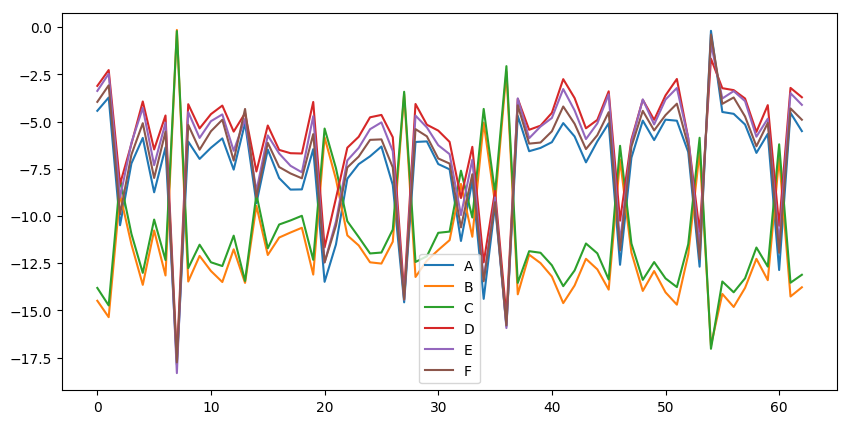

In [24]:
max_length = 5
import numpy as np
# rnn=true_training_rnn
rnn = torch.load('/Users/apple/PycharmProjects/RNN_CSE254/Sample_RNN/rnn_612_1240',map_location='cpu')
print(rnn.fc.bias)
# Sample from a category and starting letter
# def sample(keywords_dict, start_letter='A'):
plt.figure(figsize=(10,5))

for start_letter in ['A', 'B','C', 'D', 'E', 'F']:
    with torch.no_grad():  # no need to track history in sampling
    #         category_tensor = categoryTensor(category)

        _input = inputTensor(start_letter, keywords_dict)
    #         _input.to(device)
        hidden = init_prediction()
        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn.prediction(_input, hidden)
            if i==0:
                plt.plot(range(len(output[0][0])),list(output[0][0]), )
#                 plt.show()
#             topv, topi = output[0][0].topk(1)
            topi= sample(output[0][0])
#             topi = topi[0]
            letter = keywords_dict['all_letters'][topi]
            output_name += letter
            _input = inputTensor(letter, keywords_dict)
            _input.to(device)
            print(output_name)
plt.legend(['A', 'B','C', 'D', 'E', 'F'])
#     return output_name
# sample(keywords_dict)

In [1]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = preds / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    out = np.random.choice(range(len(chars)), p=probas.ravel())
    return out

In [23]:
output

tensor([[[-4.5295, -4.2618, -4.7250, -4.1999, -3.8873, -4.4217, -3.9116,
          -6.1576, -4.0623, -3.6941, -3.8243, -3.6972, -3.6403, -5.2379,
          -4.9505, -4.9698, -4.1809, -4.2422, -4.1918, -3.1671, -3.8759,
          -3.6004, -4.5704, -4.4868, -4.3364, -4.3853, -3.5229, -6.6972,
          -3.4439, -4.6452, -4.3102, -4.6888, -3.5682, -4.3517, -3.6249,
          -5.3621, -5.9188, -4.5408, -4.6330, -4.5940, -3.8339, -2.7535,
          -4.0968, -3.9654, -5.0667, -4.0870, -4.1447, -4.9680, -4.5317,
          -5.0151, -4.2508, -3.4188, -4.4272, -4.7640, -6.9407, -3.4370,
          -4.0786, -4.2549, -5.1098, -4.3449, -3.7126, -4.5071, -4.6823]]])

In [ ]:
keywords_dict['all_letters'][topi]

In [ ]:
import numpy as np
sum(np.exp(output[0][0]))

In [ ]:
output_name

tensor([ 0.0822,  0.0767,  0.0614,  0.0534,  0.0826,  0.0172,  0.0323, -0.0859,
         0.0854,  0.0246,  0.0771,  0.0868, -0.0079,  0.0285,  0.0498,  0.0258,
         0.0310, -0.0211, -0.0242,  0.0962, -0.0086, -0.0392,  0.0017,  0.0581,
         0.0826,  0.0572, -0.0321, -0.0380,  0.0704,  0.0647,  0.0523,  0.0065,
         0.0042,  0.0291, -0.0712, -0.0089, -0.0809,  0.0720,  0.0162,  0.0539,
         0.0662,  0.1156,  0.1131,  0.0220,  0.1054,  0.0940,  0.0040,  0.0428,
         0.0683,  0.0589,  0.0782,  0.1060,  0.0759, -0.0282,  0.0679,  0.1355,
         0.0825,  0.0354,  0.0552,  0.0732, -0.0537,  0.0691,  0.0536],
       requires_grad=True)
K
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
tensor([[[-3.9180, -2.8216, -4.6788, -3.9406

/Users/apple/anaconda3/lib/python3.5/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.RNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/apple/anaconda3/lib/python3.5/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/apple/anaconda3/lib/python3.5/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LogSoftmax' has changed. you can retrieve the original source code by accessing the ob

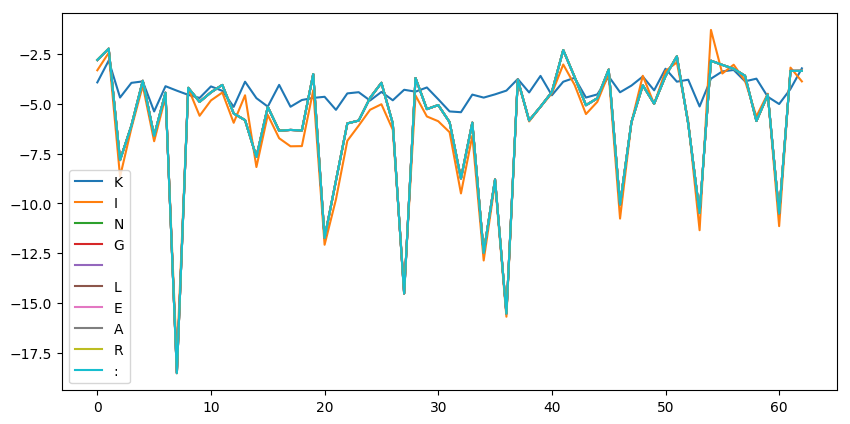

In [36]:
max_length = 5
import numpy as np
# rnn=true_training_rnn
rnn = torch.load('/Users/apple/PycharmProjects/RNN_CSE254/Sample_RNN/rnn_612_1240',map_location='cpu')
print(rnn.fc.bias)
# Sample from a category and starting letter
# def sample(keywords_dict, start_letter='A'):
plt.figure(figsize=(10,5))

# for start_letter in ['A', 'B','C', 'D', 'E', 'F']:
with torch.no_grad():  # no need to track history in sampling
    #         category_tensor = categoryTensor(category)

        _input = inputTensor(start_letter, keywords_dict)
    #         _input.to(device)
        hidden = init_prediction()
        output_name = start_letter
        for i in 'KING LEAR:':
            print(i)
            _input = inputTensor(i, keywords_dict)
            print(_input)
            _output, hidden = rnn.prediction(_input, hidden)
            print("out",_output)
            plt.plot(range(len(_output[0][0])),list(_output[0][0]), )
            
        topi= sample(_output[0][0])
        letter = keywords_dict['all_letters'][topi]
        output_name += letter
        _input = inputTensor(letter, keywords_dict)
        
        for i in range(max_length):
            output, hidden = rnn.prediction(_input, hidden)
#             if i==0:
                
#                 plt.show()
#             topv, topi = output[0][0].topk(1)
            topi= sample(output[0][0])
#             topi = topi[0]
            letter = keywords_dict['all_letters'][topi]
            output_name += letter
            _input = inputTensor(letter, keywords_dict)
            _input.to(device)
        print(output_name)
plt.legend(["K","I","N","G"," ","L","E","A","R",":"])     
    